## A-level: High-dimensional safety via discounted Safety Q-learning

In the previous sections, you implemented a grid-based HJ reachability solver and measured how runtime and memory explode with dimension $d$ (curse of dimensionality). This extension explores a modern alternative: learn an approximate safety value function without discretizing the full state space.

The goal here is not to become an RL expert. We will provide the RL scaffolding.  
Your focus is on:
- modeling choices (state, dynamics, action set),
- designing the *safety margin* $l(x)$,
- implementing the *discounted safety backup* correctly,
- and reflecting on scalability vs. guarantees.

We build on: Fisac et al., “Bridging Hamilton–Jacobi Safety Analysis and Reinforcement Learning” (ICRA 2019).

---

## Minimal RL background (what you need)

We assume a discrete-time system
$
x_{t+1} = f(x_t, a_t),
$
where:
- $x_t \in \mathbb{R}^d$ is the state,
- $a_t$ is an action chosen from a finite set (discrete actions).

In standard Q-learning, we learn a function $Q(x,a)$ that satisfies a Bellman equation.  
Here, instead of rewards, we learn safety.

---

## Safety margin $l(x)$

Define a scalar safety margin $l(x)$ such that:
- $l(x) > 0$: safe,
- $l(x) = 0$: on the boundary,
- $l(x) < 0$: safety violation.

Typical choices:
- distance to obstacles (positive outside, negative inside),
- distance to state constraints (positive inside bounds, negative outside),
- combined with a minimum to represent “worst margin”:
$
l(x) = \min\big(l_{\text{box}}(x),\; l_{\text{obstacle}}(x)\big).
$

Important: Your results will strongly depend on how you model $l(x)$.

---

## Discounted Safety Bellman backup (core idea)

HJ reachability encodes safety as a minimum over time (worst-case along a trajectory).  
Fisac et al. propose a discounted operator that is a contraction, enabling learning in high dimension.

Define the *discounted safety value*:
$
V(x) \approx \text{(discounted) worst safety margin along the future trajectory}.
$

The discounted safety Bellman equation is:
$
V(x) = (1-\gamma)\,l(x) + \gamma \min\Big(l(x),\; \max_{a} V(x')\Big),
$
where:
- $x' = f(x,a)$,
- $\gamma \in (0,1)$ is a discount factor.

In Q-form (what we implement):
$
Q(x,a) \leftarrow (1-\gamma)l(x) + \gamma \min\Big(l(x),\; \max_{a'}Q(x',a')\Big).
$

Interpretation:
- $l(x)$ is the *current* safety margin,
- $\max_{a'}Q(x',a')$ is the predicted safety from the next state under the best action,
- $\min(\cdot)$ enforces “worst margin over time” behavior.

As $\gamma \to 1$, this approaches the infinite-horizon safety objective (closer to classical reachability).

---

## What you will implement (A-level)

You are given a DQN training scaffold (network, replay buffer, training loop).  
Your tasks are to implement and justify the safety-specific parts:

### Task A1: Design and implement $l(x)$
Implement the safety margin function `l_margin(x)` for your chosen environment.

Your implementation should clearly document:
- What is considered “unsafe” and why?
- How do you combine multiple constraints (e.g., box + obstacles)?
- What dimensions matter (e.g., obstacles depend only on $x_0,x_1$ but the state is high-dimensional)?

### Task A2: Implement the discounted safety backup
Implement the target computation:
$
(1-\gamma)l(x) + \gamma \min\big(l(x), \max_{a'}Q(x',a')\big).
$

This is the most important step: verify that your code matches the equation above.

### Task A3: Evaluate and visualize safety
Even in high dimension, you can visualize results using:
- 2D slices (vary $x_0,x_1$, fix other dimensions),
- empirical violation maps (simulate rollouts and measure fraction of violations),
- rollout plots (minimum safety margin over time).

---

## Deliverables (A-level)

1. Implementation
   - Your environment (state dimension $d \ge 6$ recommended)
   - Your safety margin $l(x)$
   - Your discounted safety backup implementation
   - Training code (DQN scaffold + your modifications)

2. Results
   - Training curve(s) (loss is OK; violations over time is better)
   - A 2D slice plot of predicted safety $\hat V(x)=\max_a Q(x,a)$ and the learned boundary $\hat V=0$
   - Empirical evaluation: fraction of rollouts that violate safety

3. Short written reflection (answer the questions below)

---

## Reflection questions (answer in your report)

1. Scalability vs. guarantees:  
   Compare grid-based HJ reachability and learned safety Q-functions.  
   What do we gain (scaling)? What do we lose (guarantees)?

2. Role of $l(x)$:  
   How did your choice of safety margin affect the learned boundary?  
   What failures happen if $l(x)$ is poorly designed?

3. Effect of $\gamma$:  
   What happens when you change $\gamma$?  
   Why does increasing $\gamma$ make the objective closer to an infinite-horizon “worst margin over time”?

4. Validation:  
   Does $\hat V(x) > 0$ reliably predict “safe” rollouts in your experiments?  
   Provide at least one case where predictions and rollouts disagree, and explain why.

5. Why this matters in robotics:  
   Give one example of a realistic robot system where grid-based reachability is infeasible due to dimension, and where approximate learned safety values could still be useful.

---

### Note on grading

You are not graded on RL tricks.  
You are graded on:
- correct implementation of the safety backup,
- sound modeling and safety margin design,
- clear evaluation and interpretation of results,
- and thoughtful reflection on limitations.

In [1]:
import torch

# Task A1: Design l(x)
def student_l_margin(states):
    """
    Define the safety margin. Positive = Safe, Negative = Unsafe.
    Constraint: Keep |x,y,z| < 5 and avoid sphere at [2,2,2] with radius 1.5.
    """
    # TODO: Implement safety margin
    pass

# Task A2: Implement the Discounted Safety Bellman Backup
def safety_backup(target_net, s, s_next, l_margin_fn, gamma):
    """
    Implement Eq. 7 from Fisac et al. (2019):
    V(x) = (1-gamma)l(x) + gamma * min( l(x), max_a Q(s_next, a) )
    """
    # TODO: Implement the backup math
    pass

In [2]:
def student_l_margin(states):
    # Box constraint: distance from boundaries of [-5, 5]^3
    l_box = 5.0 - torch.norm(states[:, :3], p=float('inf'), dim=1)
    
    # Obstacle constraint: distance from sphere surface
    obs_center = torch.tensor([2.0, 2.0, 2.0]).to(states.device)
    l_obs = torch.norm(states[:, :3] - obs_center, p=2, dim=1) - 1.5
    
    # Safety is the intersection (minimum) of all margins
    return torch.min(l_box, l_obs)

def safety_backup(target_net, s, s_next, l_margin_fn, gamma):
    # Current safety margin
    l_x = l_margin_fn(s)
    
    # Max Q from next state (best available safety action)
    with torch.no_grad():
        next_q_max = target_net(s_next).max(dim=1)[0]
    
    # The Discounted Safety Bellman Equation
    targets = (1 - gamma) * l_x + gamma * torch.min(l_x, next_q_max)
    
    return targets

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from safety_rl_helper import SafetyDQNAgent, Dynamics6D

env = Dynamics6D()
agent = SafetyDQNAgent(state_dim=6, action_dim=env.action_dim, gamma=0.98)



print("Starting training...")
for ep in range(2000):
    # Random start within the safe box
    state = np.random.uniform(-4, 4, size=6)
    total_loss = 0
    
    for t in range(200):
        action = agent.select_action(state, epsilon=0.2)
        next_state = env.step(state, action)
        agent.memory.append((state, action, next_state))
        
        loss = agent.compute_loss(safety_backup, student_l_margin)
        if loss: total_loss += loss
        state = next_state
        
    if ep % 10 == 0:
        agent.update_target_net()
        print(f"Episode {ep}, Avg Loss: {total_loss/50:.4f}")



Starting training...
Episode 0, Avg Loss: 0.3934
Episode 10, Avg Loss: 0.0945
Episode 20, Avg Loss: 0.0835
Episode 30, Avg Loss: 0.0338
Episode 40, Avg Loss: 0.0169
Episode 50, Avg Loss: 0.0118
Episode 60, Avg Loss: 0.0796
Episode 70, Avg Loss: 0.0123
Episode 80, Avg Loss: 0.0068
Episode 90, Avg Loss: 0.0095
Episode 100, Avg Loss: 0.0102
Episode 110, Avg Loss: 0.0019
Episode 120, Avg Loss: 0.0022
Episode 130, Avg Loss: 0.0032
Episode 140, Avg Loss: 0.0045
Episode 150, Avg Loss: 0.0037
Episode 160, Avg Loss: 0.0039
Episode 170, Avg Loss: 0.0028
Episode 180, Avg Loss: 0.0028
Episode 190, Avg Loss: 0.0015
Episode 200, Avg Loss: 0.0019
Episode 210, Avg Loss: 0.0026
Episode 220, Avg Loss: 0.0027
Episode 230, Avg Loss: 0.0015
Episode 240, Avg Loss: 0.0022
Episode 250, Avg Loss: 0.0105
Episode 260, Avg Loss: 0.0028
Episode 270, Avg Loss: 0.0105
Episode 280, Avg Loss: 0.0026
Episode 290, Avg Loss: 0.0031
Episode 300, Avg Loss: 0.0026
Episode 310, Avg Loss: 0.0033
Episode 320, Avg Loss: 0.0031


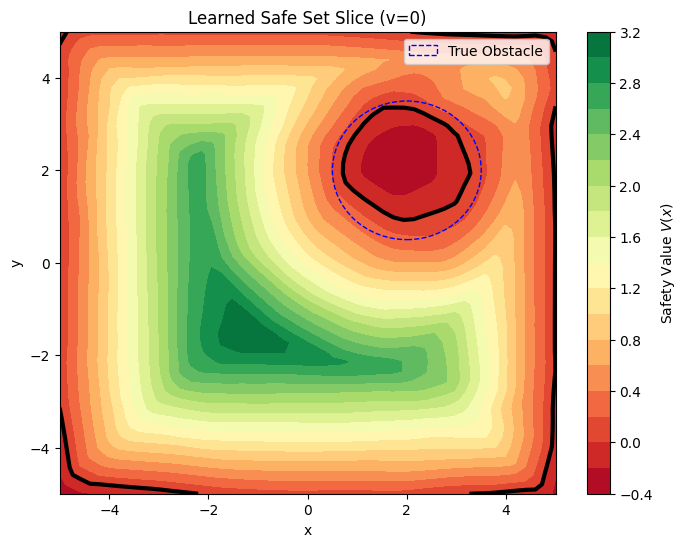

In [29]:
def plot_safe_set(agent, l_margin_fn, grid_res=50):
    # 1. Create a grid of x and y positions
    x_range = np.linspace(-5, 5, grid_res)
    y_range = np.linspace(-5, 5, grid_res)
    X, Y = np.meshgrid(x_range, y_range)
    
    # 2. Prepare states: [x, y, z=0, vx=0, vy=0, vz=0]
    # We fix the robot at z=0 and zero velocity to see the static safe set
    flat_X = X.flatten()
    flat_Y = Y.flatten()
    test_states = np.zeros((grid_res**2, 6))
    test_states[:, 0] = flat_X
    test_states[:, 1] = flat_Y
    test_states[:, 2] = 2
    
    # 3. Get Values from the Q-network
    states_t = torch.FloatTensor(test_states).to(agent.device)
    with torch.no_grad():
        # V(x) = max_a Q(x, a)
        values = agent.q_net(states_t).max(dim=1)[0].cpu().numpy()
    
    V_grid = values.reshape(grid_res, grid_res)
    
    # 4. Plotting
    plt.figure(figsize=(8, 6))
    
    # Plot the Value Function Heatmap
    cont = plt.contourf(X, Y, V_grid, levels=20, cmap='RdYlGn')
    plt.colorbar(cont, label="Safety Value $V(x)$")
    
    # Plot the Boundary (Zero-Level Set)
    plt.contour(X, Y, V_grid, levels=[0.0], colors='black', linewidths=3)
    
    # Plot the actual obstacle for comparison
    circle = plt.Circle((2, 2), 1.5, color='blue', fill=False, linestyle='--', label='True Obstacle')
    plt.gca().add_patch(circle)
    
    plt.title("Learned Safe Set Slice (v=0)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Run this after training
plot_safe_set(agent, student_l_margin)

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def interactive_safe_set(vx_value):
    grid_res = 70
    x_range = np.linspace(-6, 6, grid_res)
    y_range = np.linspace(-6, 6, grid_res)
    X, Y = np.meshgrid(x_range, y_range)
    
    # 1. Prepare states: [x, y, z=0, vx=val, vy=0, vz=0]
    test_states = np.zeros((grid_res**2, 6))
    test_states[:, 0] = X.flatten()
    test_states[:, 1] = Y.flatten()
    test_states[:, 3] = vx_value
    test_states[:, 2] = 2
    
    states_t = torch.FloatTensor(test_states).to(agent.device)
    
    with torch.no_grad():
        # 2. Get Predicted Safety Values (Learned)
        values = agent.q_net(states_t).max(dim=1)[0].cpu().numpy()
        V_grid = values.reshape(grid_res, grid_res)
        
        # 3. Get Ground Truth Safety Margin (from l_function)
        # This tells us where the obstacle physically is
        l_values = student_l_margin(states_t).cpu().numpy()
        L_grid = l_values.reshape(grid_res, grid_res)
    
    # 4. Plotting
    plt.figure(figsize=(9, 6))
    
    # The Heatmap of the LEARNED Value function
    cont = plt.contourf(X, Y, V_grid, levels=20, cmap='RdYlGn', alpha=0.7)
    plt.colorbar(cont, label="Learned Safety Value $\hat{V}(x)$")
    
    # The Learned 0-Level Set (The boundary the robot thinks is safe)
    cs_learned = plt.contour(X, Y, V_grid, levels=[0], colors='black', linewidths=3)
    
    # The GROUND TRUTH 0-Level Set (The boundary defined in Task A1)
    cs_truth = plt.contour(X, Y, L_grid, levels=[0], colors='blue', linestyles='--', linewidths=2)
    
    # Manual legend handling for contours
    h1, _ = cs_learned.legend_elements()
    h2, _ = cs_truth.legend_elements()
    plt.legend([h1[0], h2[0]], ["Learned Boundary ($\hat{V}=0$)", "True Boundary ($l(x)=0$)"])

    circle = plt.Circle((2, 2), 1.5, color='blue', fill=False, linestyle='--', label='True Obstacle')
    plt.gca().add_patch(circle)
    
    plt.title(f"Safe Set Slice at $v_x = {vx_value:.1f}$")
    plt.xlabel("x"); plt.ylabel("y")
    plt.grid(alpha=0.3)
    plt.show()

# Setup slider
vx_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.2, description='$v_x$ velocity:')
widgets.interactive(interactive_safe_set, vx_value=vx_slider)

interactive(children=(FloatSlider(value=0.0, description='$v_x$ velocity:', max=4.0, min=-4.0, step=0.2), Outp…